# Informed Search en Adversarial Search

## Informed search

In week 1 hebben we gekeken naar:
- **Uniform-cost search** (dijkstra): $f(n) = g(n)$
- waarbij
    - $f(n)$ de evaluatie functie is van node $n$
    - $g(n)$ de cumulatieve padkosten zijn van begin node naar node $n$

Bij informed search gebruiken we een heuristiek alszijnde een hint naar de oplossing
- **Greedy best-first search**: $f(n) = h(n)$
- **A\* search**: $f(n) = g(n) + h(n)$
- waarbij:
    - $h(n)$ de heuristiek is van node $n$ (in relatie tot het doel)

Bovenstaande 3 methoden kunnen we met 1 methode omvatten: 
- **Weighted A\* search**: $f(n) = g(n) + W \times h(n)$
- waarbij:
    - Uniform-cost search als $W = 0$
    - Greedy best-first search als $W = \infty$
    - A* search als $W = 1$

In [50]:
romania_map = dict(
    Arad=["Zerind", "Sibiu", "Timisoara"],
    Bucharest=["Urziceni", "Pitesti", "Giurgiu", "Fagaras"],
    Craiova=["Drobeta", "Rimnicu", "Pitesti"],
    Drobeta=["Mehadia"],
    Eforie=["Hirsova"],
    Fagaras=["Sibiu"],
    Hirsova=["Urziceni"],
    Iasi=["Vaslui", "Neamt"],
    Lugoj=["Timisoara", "Mehadia"],
    Oradea=["Zerind", "Sibiu"],
    Pitesti=["Rimnicu"],
    Rimnicu=["Sibiu"],
    Urziceni=["Vaslui"]
)

romania_loc = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))

In [51]:
from math import dist

class Node:
    def __init__(self, x, y, name=None, neighb=[], is_goal=False) -> None:
        self.x = x
        self.y = y
        self.name = name
        self.is_goal = is_goal
        self.neighb = neighb
    
    # padkosten g(n)
    def compute_path_costs(self):
        pos = [self.x, self.y]
        return [dist(pos, [n.x, n.y]) for n in self.neighb]
    
    # heuristiek h(n)
    def compute_heuristic(self, goal):
        return dist([self.x, self.y], [goal.x, goal.y])

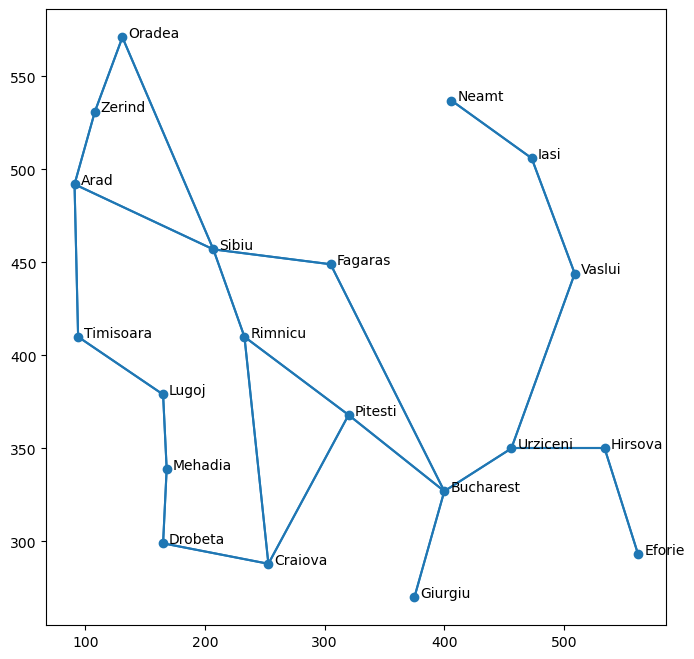

In [52]:
import matplotlib.pyplot as plt

nodes = [Node(x, y, name=name) for name, (x, y) in romania_loc.items()]

for n_i in nodes:
    n_i.neighb = [
        n_j for n_j in nodes 
        if (n_i.name in romania_map and n_j.name in romania_map[n_i.name]) or \
           (n_j.name in romania_map and n_i.name in romania_map[n_j.name])
    ]

x_vals = [n.x for n in nodes]
y_vals = [n.y for n in nodes]

plt.figure(figsize=(8, 8))
plt.scatter(x_vals, y_vals)
for n in nodes:
    plt.annotate(n.name, (n.x+5, n.y))
    for n_i in n.neighb:
        plt.plot([n.x, n_i.x], [n.y, n_i.y], c='C0')

In [53]:
import numpy as np

nodes[1].is_goal = True # Bucharest
start_node = nodes[0]   # Arad

# expand node
[(n.name, c) for n, c in zip(start_node.neighb, start_node.compute_path_costs())], start_node.compute_heuristic(nodes[1])

([('Sibiu', 121.16517651536682),
  ('Timisoara', 82.05485969764375),
  ('Zerind', 42.5440947723653)],
 350.2941620980858)

In [54]:
h = start_node.compute_heuristic(nodes[1])
[(n.name, c + h, n.compute_heuristic(nodes[1])) for n, c in zip(start_node.neighb, start_node.compute_path_costs())]

[('Sibiu', 471.4593386134526, 232.69937687926884),
 ('Timisoara', 432.3490217957295, 317.0567772497538),
 ('Zerind', 392.8382568704511, 356.20218977429096)]

In [55]:
def search(start: Node, graph: list[Node], goal: Node=None, W: float=0.5) -> list[Node]:
    if start.is_goal: return [start]
    
    queue = [(start, 0)] # (node, cumulative distance)
    
    distances = {node: float('infinity') for node in graph}
    distances[start] = 0
    shortest_path = {}
    
    while len(queue) != 0:
        current_node, current_distance = queue.pop(0)
        
        if current_node.is_goal: break

        # huidige afstand groter dan opgeslagen afstand, geen verbetering te behalen
        # we gaan backtracken
        if current_distance > distances[current_node]: 
            continue

        for neighb, cost in zip(current_node.neighb, current_node.compute_path_costs()):
            h = 0 if goal is None else neighb.compute_heuristic(goal)
            distance = current_distance + (1-W) * cost + W * h
            # cumulatieve afstand kleiner dan opgeslagen?
            # zo ja, optimize!
            if distance < distances[neighb]:
                distances[neighb] = distance
                queue.append((neighb, distance))
                shortest_path[neighb] = current_node

        queue.sort(key=lambda n: n[1])

    path = []
    end = current_node
    while end:
        path.insert(0, (end.name, distances[end]))
        end = shortest_path.get(end)

    return path

astar_path = search(start_node, nodes, nodes[1], W=0.5)
dijks_path = search(start_node, nodes)

astar_path, dijks_path

([('Arad', 0),
  ('Sibiu', 176.93227669731783),
  ('Fagaras', 303.40794774936995),
  ('Bucharest', 380.72062458829464)],
 [('Arad', 0),
  ('Sibiu', 60.58258825768341),
  ('Rimnicu', 87.43868626167497),
  ('Pitesti', 135.74241282598882),
  ('Bucharest', 180.689604061927)])

https://qiao.github.io/PathFinding.js/visual/

## Adverserial Search

We behandelen **zero-sum games**:
- utility(player0) + utility(player1) = 0
- dus als ik $+V$ krijg, dan krijgt de tegenstander $-V$
- Ik wil de waarde van mijn actie **maximaliseren**
- Mijn tegenstander wilt de van mijn actie **minimaliseren**  

Voorbeeld matching pennies game:

||Kop|Munt|
|--|--|--|
|**Kop**|-1, 1|1, -1|
|**Munt**|1, -1|-1, 1|

De som van utiliteiten is altijd 0. 

Ander voorbeeld: tic-tac-toe
- als de $X$ speler (max) wint, utility: +1
- als de $O$ speler (min) wint, utility: -1
- bij gelijk spel, utility: 0

In [56]:
board = np.array([[' ' for _ in range(3)] for _ in range(3)])
# np.fill_diagonal(board, 'o')
board[1, :1] = 'x'

board

array([[' ', ' ', ' '],
       ['x', ' ', ' '],
       [' ', ' ', ' ']], dtype='<U1')

In [57]:
def check_winner(board):
    if (np.diag(board) == 'x').all() or (np.diag(np.fliplr(board)) == 'x').all() or \
       (board == 'x').all(0).any() or (board == 'x').all(1).any():
        return 'x'
    elif (np.diag(board) == 'o').all() or (np.diag(np.fliplr(board)) == 'o').all() or \
       (board == 'o').all(0).any() or (board == 'o').all(1).any():
        return 'o'
    elif (board == ' ').any():
        return None
    else:
        return 'tie'

check_winner(board)

In [63]:
np.where(board == ' '), board

((array([0, 0, 0, 1, 1, 2, 2, 2]), array([0, 1, 2, 1, 2, 0, 1, 2])),
 array([[' ', ' ', ' '],
        ['x', ' ', ' '],
        [' ', ' ', ' ']], dtype='<U1'))

In [66]:
def minimax(board, player, alpha, beta, depth):
    winner = check_winner(board)
    if winner == 'x':
        return 1.0 - (depth/board.size) # penalty term
    elif winner == 'o':
        return -1.0 + (depth/board.size) # penalty term
    elif winner == 'tie':
        return 0.0
    
    if player == 'max':
        max_eval = float('-inf')
        for i, j in zip(*np.where(board == ' ')):
            board[i, j] = 'o'
            eval = minimax(board, 'min', alpha, beta, depth+1)
            board[i, j] = ' '
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha: break
        return max_eval

    elif player == 'min':
        min_eval = float('inf')
        for i, j in zip(*np.where(board == ' ')):
            board[i, j] = 'x'
            eval = minimax(board, 'max', alpha, beta, depth+1)
            board[i, j] = ' '
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta >= alpha: break
        return min_eval

minimax(board, 'min', float('-inf'), float('inf'), 0)

0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777778
0.8888888888888888
0.6666666666666666
0.6666666666666666
0.7777777777777778
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777778
0.8888888888888888
0.7777777777777778
0.6666666666666666
0.7777777777777778
0.6666666666666666
0.7777777777777778
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777778
0.8888888888888888
0.7777777777777778
0.6666666666666666
0.7777777777777778
0.6666666666666666
0.7777777777777778
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777778
0.6666666666666666
0.7777777777777778
0.6666666666666666
0.7777777777777778
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777778
0.6666666666666666
0.7777777777777778
0.6666666666666666
0.7777777777777778
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.666666

0.4444444444444444

In [59]:
# min speler aan de beurt

best_score = float('inf')
best_action = None
for i, j in zip(*np.where(board == ' ')):
    board[i, j] = 'o'
    score = minimax(board, 'min', float('-inf'), float('inf'), 0)
    board[i, j] = ' '
    if score < best_score:
        best_score = score
        best_action = (i, j)

best_score, best_action

(0.4444444444444444, (0, 0))